# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

# Boosting

La idea general de la mayoría de los métodos de boosting es entrenar predictores secuencialmente, cada uno de los cuales intenta corregir a su predecesor. Existen muchos métodos de boosting, pero los más populares son AdaBoost (abreviatura de adaptive boosting) y el gradient boosting. Empecemos por AdaBoost

## AdaBoost

Una forma de que un nuevo predictor corrija a su predecesor es prestar un poco más de atención a las instancias de entrenamiento que el predecesor infraajustó. Esto hace que los nuevos predictores se centren cada vez más en los casos difíciles. Esta es la técnica utilizada por AdaBoost.

Por ejemplo, al entrenar un clasificador AdaBoost, el algoritmo entrena primero un clasificador base (como un árbol de decisión) y lo utiliza para hacer predicciones sobre el conjunto de entrenamiento. A continuación, el algoritmo aumenta el peso relativo de las instancias de entrenamiento mal clasificadas.

A continuación, entrena un segundo clasificador, utilizando los pesos actualizados, y vuelve a realizar predicciones sobre el conjunto de entrenamiento, actualiza los pesos de las instancias, y así sucesivamente como se ve en la figura a continuación.

La Figura muestra los límites de decisión de cinco predictores consecutivos en el conjunto de datos de lunas (en este ejemplo, cada predictor es un clasificador SVM altamente regularizado con un núcleo RBF). 

El primer clasificador se equivoca en muchos casos, por lo que sus pesos se incrementan. Por tanto, el segundo clasificador realiza un mejor trabajo en estos casos, y así sucesivamente. 

El gráfico de la derecha representa la misma secuencia de predictores, salvo que la tasa de aprendizaje se reduce a la mitad (es decir, las ponderaciones de las instancias mal clasificadas se potencian mucho menos en cada iteración). 

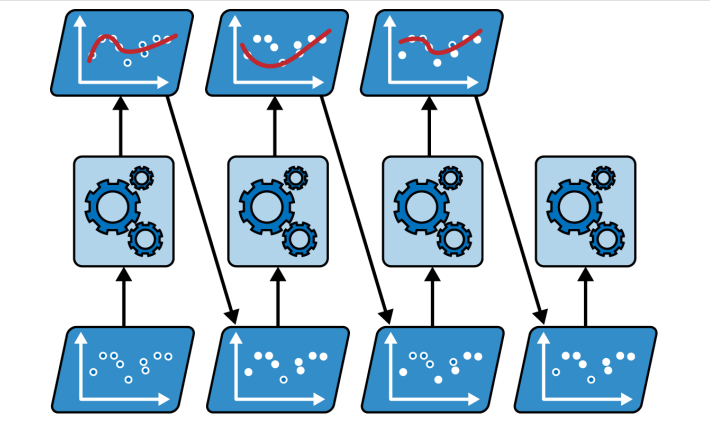

Una vez entrenados todos los predictores, el ensemble realiza predicciones muy parecidas a las de bagging o pasting, con la diferencia de que los predictores tienen distintos pesos en función de su precisión global en el conjunto de entrenamiento ponderado.


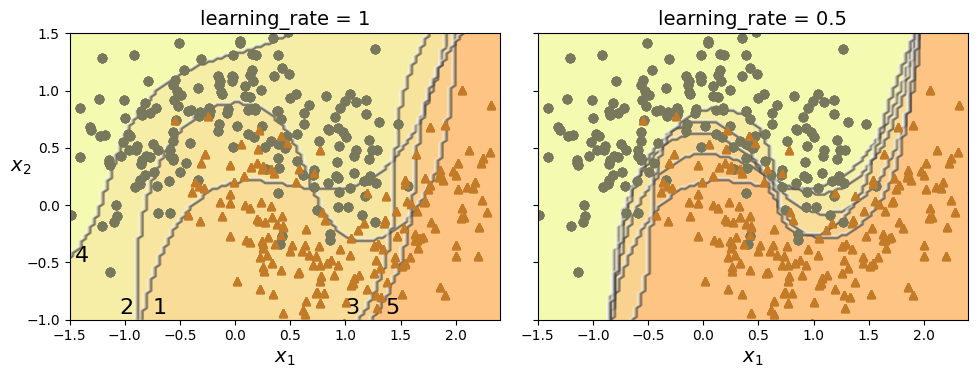

In [7]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

Esta técnica de aprendizaje secuencial tiene un importante inconveniente: el entrenamiento no puede paralelizarse, ya que cada predictor sólo puede entrenarse después de que el predictor anterior haya sido entrenado y evaluado. Como resultado, no es tan escalable como el bagging o el pasting ya uqe no se puede paralelizar

Echemos un vistazo al algoritmo AdaBoost. El peso de cada instancia $w^(i)$ se fija inicialmente en $1/m$. Se entrena un primer predictor y se calcula su tasa de error ponderado r1 en el conjunto de entrenamiento.

Tasa de error ponderada del j-ésimo predictor

$$
r_j = \sum_{i=1}^{m} w_i \cdot \mathbb{1}(y^{(j)}_i \neq y_i)
$$

Donde:

- $ r_j $ es la tasa de error ponderada del j-ésimo predictor.
- $ m $ es el número total de instancias.
- $ w_i $ es el peso asociado a la i-ésima instancia.
- $ y^{(j)}_i $ es la predicción del j-ésimo predictor para la i-ésima instancia.
- $ y_i $ es la etiqueta verdadera de la i-ésima instancia.
- $ \mathbb{1}(y^{(j)}_i \neq y_i) $ es una función indicadora que toma el valor 1 cuando la predicción del j-ésimo predictor para la i-ésima instancia es diferente de la etiqueta verdadera, y 0 en caso contrario.


El peso del predictor $α_j$ se calcula mediante la ecuación, donde $η$ es el hiperparámetro de la tasa de aprendizaje (por defecto es 1). Cuanto más preciso sea el predictor, mayor será su peso. Si sólo acierta al azar, su ponderación será cercana a cero. Sin embargo, si la mayoría de las veces se equivoca (es decir, es menos preciso que adivinar al azar), su peso será negativo.

Peso del predictor

$$\alpha_j = η log \frac{1-r_j}{r_j}$$

A continuación, el algoritmo AdaBoost actualiza los pesos de las instancias, utilizando la ecuación, que potencia los pesos de las instancias mal clasificadas.

Para $ i = 1, 2, \cdots, m $:

$$
w_i^{(\text{nuevo})} = \begin{cases} 
w_i & \text{si } y^{(j)}_i = y_i \\
w_i \cdot \exp(\alpha_j) & \text{si } y^{(j)}_i \neq y_i
\end{cases}
$$

Donde:

- $ w_i $ es el peso actual de la i-ésima instancia.
- $ y^{(j)}_i $ es la predicción del j-ésimo predictor para la i-ésima instancia.
- $ y_i $ es la etiqueta verdadera de la i-ésima instancia.
- $ \alpha_j $ es un parámetro asociado con el j-ésimo predictor, generalmente relacionado con su precisión.
- $ w_i^{(\text{nuevo})} $ es el nuevo peso de la i-ésima instancia después de la actualización.

A continuación, se normalizan todos los pesos de instancia (es decir, se dividen por $\sum^m_{i=1} w^{(i)}$).

Por último, se entrena un nuevo predictor con los pesos actualizados y se repite todo el proceso: se calcula el peso del nuevo predictor, se actualizan los pesos de la instancia, se entrena otro predictor y así sucesivamente. El algoritmo se detiene cuando se alcanza el número deseado de predictores o cuando se encuentra un predictor perfecto. Para hacer predicciones, AdaBoost simplemente calcula las predicciones de todos los predictores y las pondera utilizando los pesos de predictor $α_j$ . La clase predicha es la que recibe la mayoría de los votos ponderados.

$$
\hat{y}(x) = \underset{k}{\mathrm{argmax}} \sum_{\substack{j=1 \\ y^{(j)}(x) = k}}^{N} \alpha_j
$$

Donde:

- $ \hat{y}(x) $ es la predicción del modelo AdaBoost para la entrada $ x $.
- El término $ \underset{k}{\mathrm{argmax}} $ significa que estamos eligiendo la clase $ k $ que maximiza la suma que le sigue.
- $ y^{(j)}(x) $ es la predicción de la clase $ k $ hecha por el j-ésimo predictor para la entrada $ x $.
- $ \alpha_j $ es el peso del j-ésimo predictor en el ensamblaje.
- $ N $ es el número total de predictores en el ensamblaje.


Scikit-Learn utiliza una versión multiclase de AdaBoost llamada SAMME (que significa Stagewise Additive Modeling using a Multiclass Exponential loss function). Cuando sólo hay dos clases, SAMME es equivalente a AdaBoost.

Si los predictores pueden estimar las probabilidades de clase (es decir, si tienen un método predict_proba()), Scikit-Learn puede utilizar una variante de SAMME denominada SAMME.R (la R significa "Real"), que se basa en las probabilidades de clase en lugar de en las predicciones y, por lo general, obtiene mejores resultados. Pero no le toméis mucho cariño porque lo van a deprecar.

El siguiente código entrena un clasificador AdaBoost basado en 30 decision stumps utilizando la clase AdaBoostClassifier de Scikit-Learn (como era de esperar, también hay una clase AdaBoostRegressor). Un decision stumps es un árbol de decisión con max_depth=1, es decir, un árbol compuesto por un único nodo de decisión más dos nodos hoja. Este es el estimador base por defecto para la clase AdaBoostClassifier:

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

c:\Users\Jonatan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

Si su conjunto AdaBoost está ajustando en exceso el conjunto de entrenamiento, puede intentar reducir el número de estimadores o regularizar más fuertemente el estimador base.

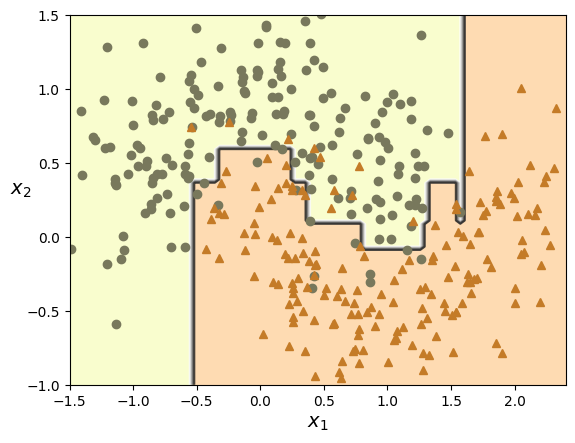

In [19]:
# en caso de que tenga curiosidad por ver cómo es el límite de decisión
# para el clasificador AdaBoost
plot_decision_boundary(ada_clf, X_train, y_train)

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracy_score(y_test, ada_clf.predict(X_test))

0.904

In [21]:
recall_score(y_test, ada_clf.predict(X_test))

0.859375

In [22]:
precision_score(y_test, ada_clf.predict(X_test))

0.9482758620689655

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42, algorithm="SAMME")
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracy_score(y_test, ada_clf.predict(X_test))

0.88

In [25]:
recall_score(y_test, ada_clf.predict(X_test))

0.78125

In [26]:
precision_score(y_test, ada_clf.predict(X_test))

0.9803921568627451

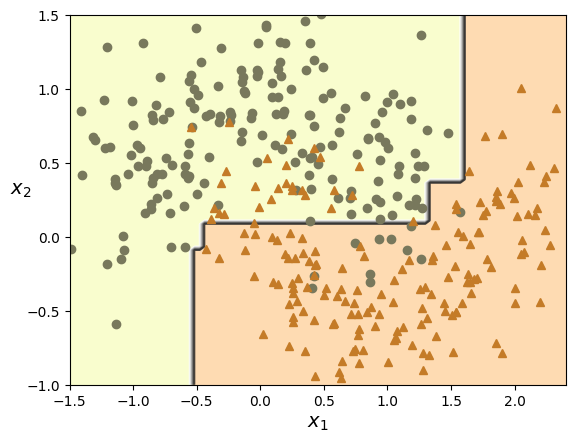

In [11]:
# en caso de que tenga curiosidad por ver cómo es el límite de decisión
# para el clasificador AdaBoost
plot_decision_boundary(ada_clf, X_train, y_train)

In [27]:
# Hasta aquí llegó la tortura de replicar los algoritmos por dentro.
# Tendremos que confiar en el feature_importance y otras métricas ya que la visilidad es muy baja a este nivel.

[DecisionTreeClassifier(max_depth=1, random_state=1608637542),
 DecisionTreeClassifier(max_depth=1, random_state=1273642419),
 DecisionTreeClassifier(max_depth=1, random_state=1935803228),
 DecisionTreeClassifier(max_depth=1, random_state=787846414),
 DecisionTreeClassifier(max_depth=1, random_state=996406378),
 DecisionTreeClassifier(max_depth=1, random_state=1201263687),
 DecisionTreeClassifier(max_depth=1, random_state=423734972),
 DecisionTreeClassifier(max_depth=1, random_state=415968276),
 DecisionTreeClassifier(max_depth=1, random_state=670094950),
 DecisionTreeClassifier(max_depth=1, random_state=1914837113),
 DecisionTreeClassifier(max_depth=1, random_state=669991378),
 DecisionTreeClassifier(max_depth=1, random_state=429389014),
 DecisionTreeClassifier(max_depth=1, random_state=249467210),
 DecisionTreeClassifier(max_depth=1, random_state=1972458954),
 DecisionTreeClassifier(max_depth=1, random_state=1572714583),
 DecisionTreeClassifier(max_depth=1, random_state=1433267572),


# Sobre el Learning Rate

## Definición habitual

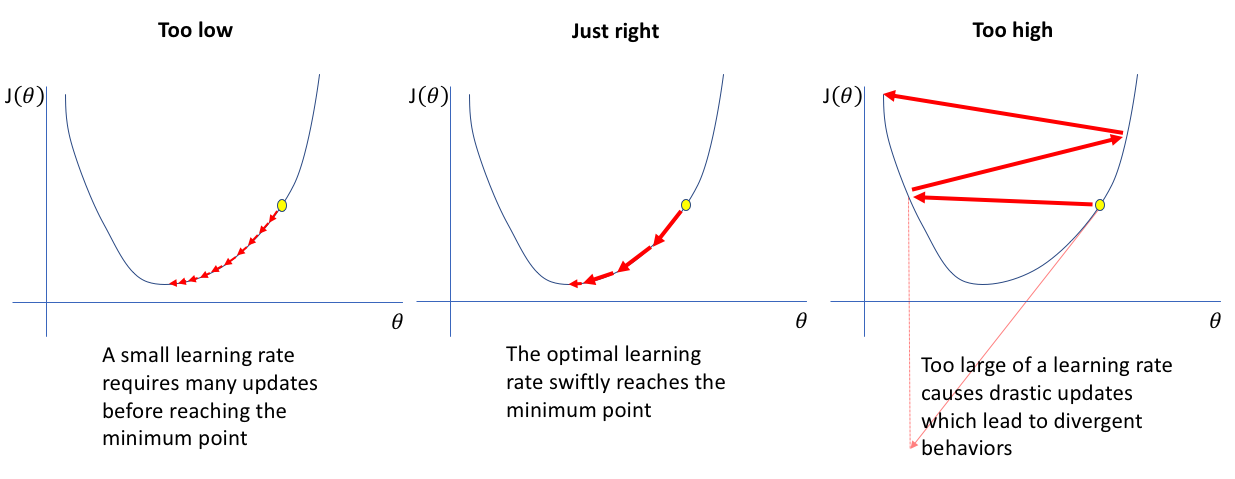

Cuando intentamos optimizar la curva de arriba para llegar al mínimo, necesitamos dar "saltos" en la dirección acertada. Saltos muy pequeños hacen que se demore más la optimización, saltos muy grandes pueden tener efectos "explosivos"

Además, hay que añadir la complejidad de que casi nunca será una curvita suave, como la de arriba, sino un gráfico terrible en n-dimensiones, imposible de ver al ojo humano y posiblemente con mínimos relativos y/o varios mínimos absolutos

## Defición Boosting:

**"The learning rate shrinks the contribution of each regressor by learning_rate."**

Puesto que la idea del algoritmo es ir mejorando a cada iteración, tiene sentido que los primeros estimadores tengan menos peso que los últimos.

## Gradient Boosting

Otro algoritmo de refuerzo muy popular es el refuerzo por gradiente. Al igual que AdaBoost, gradient boosting funciona añadiendo secuencialmente predictores a un conjunto, cada uno de los cuales corrige a su predecesor. Sin embargo, en lugar de ajustar los pesos de instancia en cada iteración como hace AdaBoost, este método intenta ajustar el nuevo predictor a los errores residuales cometidos por el predictor anterior.

Veamos un ejemplo de regresión simple, utilizando árboles de decisión como predictores de base; esto se llama gradient tree boosting, o gradient boosted regression trees (GBRT). En primer lugar, vamos a generar un conjunto de datos cuadráticos ruidosos y ajustar un DecisionTreeRegressor a la misma:

Vamos a crear un conjunto de datos cuadrático simple y a ajustarle un `DecisionTreeRegressor`:

In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + ruido Gaussian

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Ahora vamos a entrenar otro árbol de decisión regresor sobre los errores residuales cometidos por el predictor anterior:

In [30]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

Y luego entrenaremos un tercer regresor sobre los errores residuales cometidos por el segundo predictor:

In [31]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Ahora tenemos un ensemble que contiene tres árboles. Puede hacer predicciones sobre una nueva instancia simplemente sumando las predicciones de todos los árboles:

In [32]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

La Figura a continuación representa las predicciones de estos tres árboles en la columna de la izquierda, y las predicciones del conjunto en la columna de la derecha. En la primera fila, el conjunto sólo tiene un árbol, por lo que sus predicciones son exactamente las mismas que las del primer árbol. 

En la segunda fila, se entrena un nuevo árbol con los errores residuales del primer árbol. A la derecha puede ver que las predicciones del conjunto son iguales a la suma de las predicciones de los dos primeros árboles. 

Del mismo modo, en la tercera fila se entrena otro árbol con los errores residuales del segundo árbol. Puede ver que las predicciones del conjunto mejoran gradualmente a medida que se añaden árboles al conjunto. 

Puede utilizar la clase GradientBoostingRegressor de Scikit-Learn para entrenar conjuntos GBRT más fácilmente (también hay una clase GradientBoostingClassifier para clasificación). 

Al igual que la clase RandomForestRegressor, tiene hiperparámetros para controlar el crecimiento de los árboles de decisión (por ejemplo, max_depth, min_samples_leaf), así como hiperparámetros para controlar el entrenamiento del ensemble, como el número de árboles (n_estimators). El siguiente código crea el mismo ensemble que el anterior:

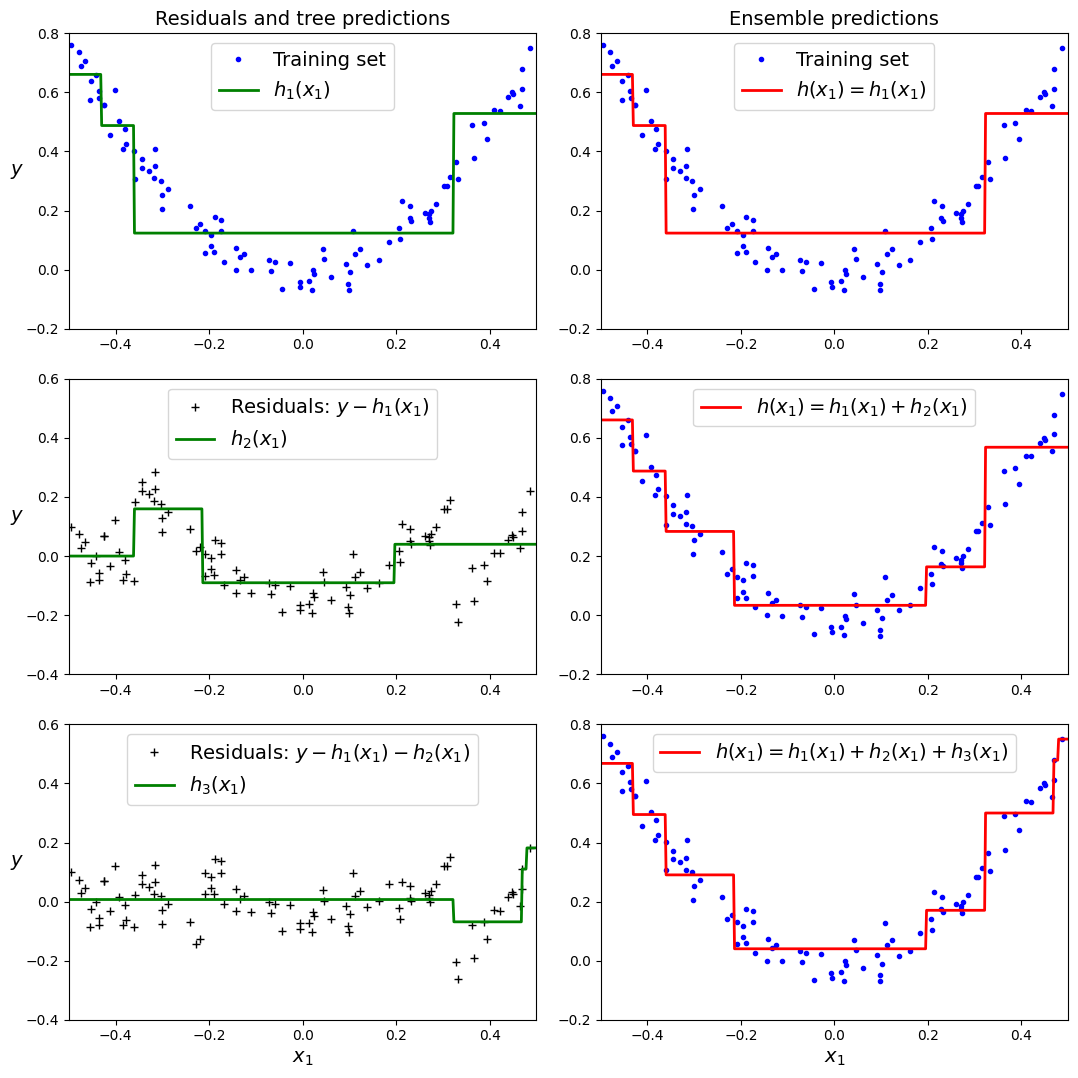

In [34]:

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

Ahora probemos con un regresor de gradiente:

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [47]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=60,
                                 learning_rate=0.05, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=60,
                          random_state=42)

El hiperparámetro learning_rate escala la contribución de cada árbol. Si lo establece en un valor bajo, como 0,05, necesitará más árboles en el ensemble para ajustarse al conjunto de entrenamiento, pero las predicciones normalmente se generalizarán mejor. Se trata de una técnica de regularización llamada contracción o `shrinkage`. 

La Figura muestra dos conjuntos GBRT entrenados con diferentes hiperparámetros: el de la izquierda no tiene suficientes árboles para ajustarse al conjunto de entrenamiento, mientras que el de la derecha tiene la cantidad adecuada. Si añadiéramos más árboles, la GBRT empezaría a sobreajustarse al conjunto de entrenamiento.

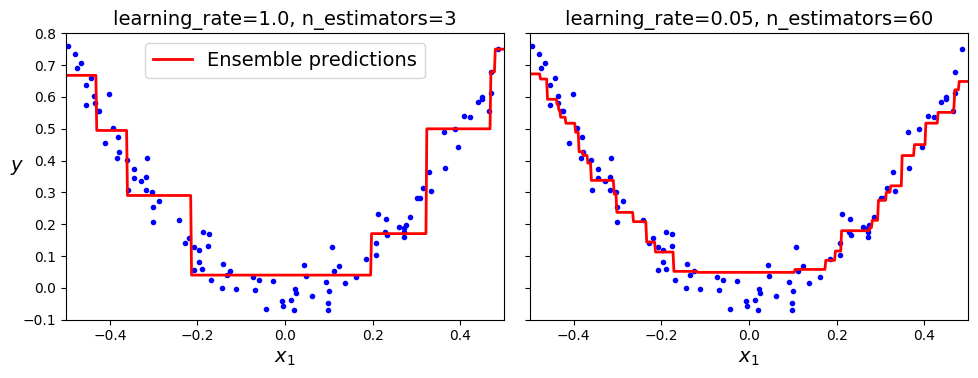

In [49]:

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

Para encontrar el número óptimo de árboles, podría realizar un Cross Validation utilizando GridSearchCV o RandomizedSearchCV.

Pero hay una forma más sencilla: si establece el hiperparámetro n_iter_no_change en un valor entero, digamos 10, entonces el Gradient BoostingRegressor dejará automáticamente de añadir más árboles durante el entrenamiento si ve que los últimos 10 árboles no ayudaron. 

Esto es simplemente un early stopping, pero con un poco de paciencia: tolera no tener ningún progreso durante unas pocas iteraciones antes de detenerse. Entrenemos el conjunto utilizando el early stopping

In [50]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

Si establece n_iter_no_change demasiado bajo, el entrenamiento puede detenerse demasiado pronto y el modelo no se ajustará lo suficiente. Pero si es demasiado alto, el modelo se ajustará demasiado. También fijamos una tasa de aprendizaje bastante pequeña y un número elevado de estimadores, pero el número real de estimadores en el conjunto entrenado es mucho menor, gracias al early stopping:

In [51]:
gbrt_best.n_estimators_


92

Cuando se establece n_iter_no_change, el método fit() divide automáticamente el conjunto de entrenamiento en un conjunto de entrenamiento más pequeño y un conjunto de validación: esto le permite evaluar el rendimiento del modelo cada vez que añade un nuevo árbol. El tamaño del conjunto de validación se controla mediante el hiperparámetro validation_fraction, que es el 10% por defecto. El hiperparámetro tol determina la mejora máxima del rendimiento que se considera insignificante. Por defecto es 0,0001.

La clase GradientBoostingRegressor también admite un hiperparámetro de subsample, que especifica la fracción de instancias de entrenamiento que se utilizarán para entrenar cada árbol. Por ejemplo, si subsample=0,25, cada árbol se entrena con el 25% de las instancias de entrenamiento, seleccionadas aleatoriamente. Como ya habrá adivinado, esta técnica cambia un mayor sesgo por una menor varianza. También acelera considerablemente el entrenamiento. Es lo que se denomina stochastic gradient boosting.